Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
step 0, training accuracy 0.0859375, test accuracy 0.10000000149011612, training loss 3.3376832008361816, test loss 3.1270086765289307
step 50, training accuracy 0.2265625, test accuracy 0.19099999964237213, training loss 2.2591848373413086, test loss 2.2576661109924316
step 100, training accuracy 0.265625, test accuracy 0.2290000021457672, training loss 2.1412572860717773, test loss 2.1306779384613037
step 150, training accuracy 0.296875, test accuracy 0.2939999997615814, training loss 2.011354684829712, test loss 2.0361082553863525
step 200, training accuracy 0.3515625, test accura

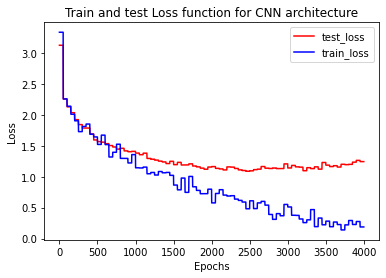

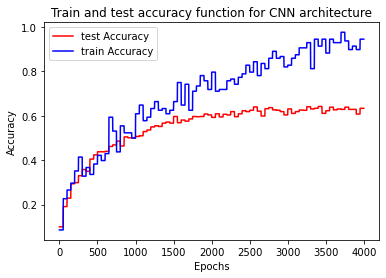

In [2]:
import os
import datetime
from scipy import misc
import imageio
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib as mp
from math import sqrt
if(tf.__version__.split('.')[0]=='2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()    

def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''
    initial = tf.truncated_normal(shape, stddev=0.1)
    W = tf.Variable(initial)
    return W

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''
    initial = tf.constant(0.1, shape = shape)
    b = tf.Variable(initial)
    return b

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''
    h_conv = tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')
    return h_conv

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''
    h_max = tf.nn.max_pool(x, ksize = [1, 2, 2, 1],
                             strides = [1, 2, 2, 1],
                             padding = 'SAME')
    return h_max

ntrain = 1000 # per class
ntest =  100 # per class
nclass =  10 # number of classes
imsize = 28
nchannels = 1
batchsize = 128

Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
Test = np.zeros((ntest*nclass,imsize,imsize,nchannels))
LTrain = np.zeros((ntrain*nclass,nclass))
LTest = np.zeros((ntest*nclass,nclass))

itrain = -1
itest = -1
for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        path = './CIFAR10/CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
        im = imageio.imread(path); # 28 by 28
        im = im.astype(float)/255
        itrain += 1
        Train[itrain,:,:,0] = im
        LTrain[itrain,iclass] = 1 # 1-hot lable
    for isample in range(0, ntest):
        path = './CIFAR10/CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
        im = imageio.imread(path); # 28 by 28
        im = im.astype(float)/255
        itest += 1
        Test[itest,:,:,0] = im
        LTest[itest,iclass] = 1 # 1-hot lable

sess = tf.InteractiveSession()

def main():
    result_dir = './results/' # directory where the results from the training are saved
    max_step = 4000 

    # placeholders for input data and input labeles
    x  = tf.placeholder(tf.float32, [None, 28, 28, 1], name = 'x')
    y_ = tf.placeholder(tf.float32, [None, 10], name = 'y_')

    # first convolutional layer
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    h_pool1_bn = tf.layers.batch_normalization(h_pool1)

    # second convolutional layer
    W_conv2 = weight_variable([3, 3, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1_bn, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    h_pool2_bn = tf.layers.batch_normalization(h_pool2)
    
    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_pool2_drop = tf.nn.dropout(h_pool2_bn, keep_prob)
	# third convolutional layer
    W_conv3 = weight_variable([3, 3, 64, 64])
    b_conv3 = bias_variable([64])
    h_conv3 = tf.nn.relu(conv2d(h_pool2_drop, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    h_conv3_bn = tf.layers.batch_normalization(h_pool3)
    
    # densely connected layer
    W_fc1 = weight_variable([4 * 4 * 64, 256])
    b_fc1 = bias_variable([256])
    h_pool2_flat = tf.reshape(h_conv3_bn, [-1, 4 * 4 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # dropout
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # softmax
    W_fc2 = weight_variable([256, 10])
    b_fc2 = bias_variable([10])
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name = 'y')

    # setup training
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), 
                                                     reduction_indices = [1]))
    train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = 'accuracy') 
                        
    
    # Add the variable initializer Op.
    init = tf.global_variables_initializer()
    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    # Run the Op to initialize the variables.
    sess.run(init)

    trainLoss = []
    testLoss = []
    trainAcc = []
    testAcc = []
    steps = []
    # run the training
    displayStep = 50

    # Op to initialize the variables.
    sess.run(tf.global_variables_initializer())
    batch_xs = np.zeros((batchsize, 28, 28, 1))
    batch_ys = np.zeros((batchsize, nclass))
    nsamples = len(Train)
    for i in range(max_step):
        perm = np.arange(nsamples)
        np.random.shuffle(perm)
        for j in range(batchsize):
            batch_xs[j,:,:,:] = Train[perm[j],:,:,:]
            batch_ys[j,:] = LTrain[perm[j],:]

        if i%displayStep == 0:
            # output the training accuracy every 100 iterations
            train_accuracy = accuracy.eval(feed_dict = {
                x: batch_xs, y_:batch_ys, keep_prob: 1.0})
            train_loss = cross_entropy.eval(feed_dict = {
                x: batch_xs, y_:batch_ys, keep_prob: 1.0})
            #output the test accuracy every 100 iterations
            test_accuracy = accuracy.eval(feed_dict = {
                x: Test, y_: LTest, keep_prob: 1.0})
            #output the test loss every 100 iterations
            test_loss = cross_entropy.eval(feed_dict = {
                x: Test, y_: LTest, keep_prob: 1.0})
            
            
            print("step {}, training accuracy {}, test accuracy {}, training loss {}, test loss {}".format(i, train_accuracy, test_accuracy, train_loss, test_loss))

        # save the checkpoints every 1100 iterations
        if i % 100 == 0 or i == max_step:
            checkpoint_file = os.path.join(result_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=i)

        testLoss.append(test_loss)
        trainLoss.append(train_loss)
        testAcc.append(test_accuracy)
        trainAcc.append(train_accuracy)
        steps.append(i)
        
        train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5}) 
    
    #plot the train, validation and test loss function
    plt.figure()
    plt.plot(steps, testLoss, 'r-', label = 'test_loss')
    plt.plot(steps, trainLoss, 'b-', label = 'train_loss')
    plt.title('Train and test Loss function for CNN architecture')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #plot the train, validation and test accuracy
    plt.figure()
    plt.plot(steps, testAcc, 'r-', label = 'test Accuracy')
    plt.plot(steps, trainAcc, 'b-', label = 'train Accuracy')
    plt.title('Train and test accuracy function for CNN architecture')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
if __name__ == "__main__":
    main()